### Imports

In [1]:
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re

In [2]:
import nltk
from nltk.tokenize import casual_tokenize
from nltk.stem import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer

In [3]:
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, ConfusionMatrixDisplay, confusion_matrix
from keras.models import Model
from keras.layers import Dense, Concatenate, Input, Dropout, BatchNormalization
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
import optuna

2024-01-29 21:02:30.357353: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-01-29 21:02:30.358872: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-29 21:02:30.382061: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-29 21:02:30.382089: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-29 21:02:30.382107: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to regi

In [4]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /home/damian/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

### Reading data

In [5]:
df = pd.read_csv('train.csv', header=0)
df = df.dropna(axis=0)
df

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0
...,...,...,...,...,...,...
404285,404285,433578,379845,How many keywords are there in the Racket prog...,How many keywords are there in PERL Programmin...,0
404286,404286,18840,155606,Do you believe there is life after death?,Is it true that there is life after death?,1
404287,404287,537928,537929,What is one coin?,What's this coin?,0
404288,404288,537930,537931,What is the approx annual cost of living while...,I am having little hairfall problem but I want...,0


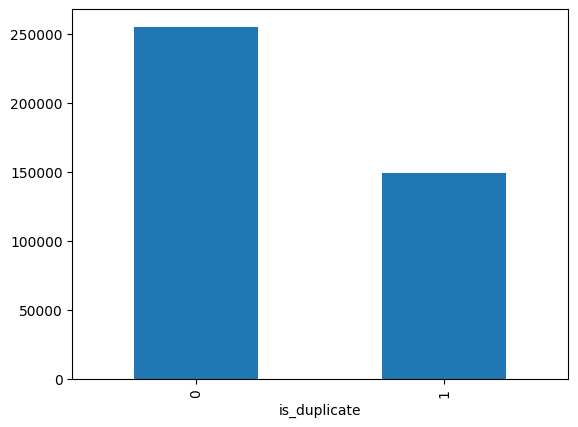

In [6]:
df['is_duplicate'].astype('category').value_counts().plot.bar()
plt.show()

### Text preprocess

In [7]:
def process_text(text):

    text = text.lower()
    tokens = casual_tokenize(text)
    tokens = [re.sub(r'[^a-zA-Z]', '', token) for token in tokens]
    stemmer = PorterStemmer()
    stemmed_tokens = [stemmer.stem(token) for token in tokens]
    processed_text = " ".join(stemmed_tokens)
    
    return processed_text

In [8]:
df['question1'] = df['question1'].apply(process_text)
df['question2'] = df['question2'].apply(process_text)
df

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,what is the step by step guid to invest in sha...,what is the step by step guid to invest in sha...,0
1,1,3,4,what is the stori of kohinoor kohinoor diamond,what would happen if the indian govern stole t...,0
2,2,5,6,how can i increas the speed of my internet con...,how can internet speed be increas by hack thro...,0
3,3,7,8,whi am i mental veri lone how can i solv it,find the remaind when math math is d...,0
4,4,9,10,which one dissolv in water quikli sugar salt ...,which fish would surviv in salt water,0
...,...,...,...,...,...,...
404285,404285,433578,379845,how mani keyword are there in the racket progr...,how mani keyword are there in perl program lan...,0
404286,404286,18840,155606,do you believ there is life after death,is it true that there is life after death,1
404287,404287,537928,537929,what is one coin,what thi coin,0
404288,404288,537930,537931,what is the approx annual cost of live while s...,i am have littl hairfal problem but i want to ...,0


### Creating TFIDF vectors

In [9]:
wektor_tf_idf_size = 5000

In [10]:
corpus = df['question1'].tolist() + df['question2'].tolist()

model = TfidfVectorizer(max_features=wektor_tf_idf_size)
tfidf_vectors = model.fit_transform(corpus)

### Creating and splitting datasets

In [11]:
X1 = np.array([tfidf_vector for tfidf_vector in tfidf_vectors[:len(df)]])
X2 = np.array([tfidf_vector for tfidf_vector in tfidf_vectors[len(df):]])
y = np.array(df['is_duplicate'])

In [12]:
X1_train, X1_test, X2_train, X2_test, y_train, y_test = train_test_split(X1, X2, y, test_size=0.2, random_state=42)

In [13]:
def data_generator(X1, X2, y, batch_size, epochs):
    num_samples = X1.shape[0]
    num_batches = int(np.ceil(num_samples / batch_size))
    
    for epoch in range(epochs):
        for i in range(num_batches):
            start_idx = i * batch_size
            end_idx = min((i + 1) * batch_size, num_samples)
    
            batch_indices = np.arange(start_idx, end_idx)
            X1_batch_sparse = X1[batch_indices]
            X2_batch_sparse = X2[batch_indices]

            X1_batch_dense = np.vstack([convert_to_dense(x) for x in X1_batch_sparse])
            X2_batch_dense = np.vstack([convert_to_dense(x) for x in X2_batch_sparse])

            y_batch = y[batch_indices]
            
            yield [X1_batch_dense, X2_batch_dense], y_batch

def convert_to_dense(sparse_vector):
    return sparse_vector.toarray().flatten()

### Optuna

### Final model

In [14]:
params = {
    'number_of_layers': 1,
    'dense_units': 512,
    'dropout_rate': 0.5,
    'learning_rate': 0.01,
}

In [15]:
input_a = Input(shape=(wektor_tf_idf_size,))
input_b = Input(shape=(wektor_tf_idf_size,))

branch_a = Dense(params['dense_units'], activation='relu')(input_a)
branch_a = Dropout(params['dropout_rate'])(branch_a)
for i in range(params['number_of_layers']):
    branch_a = Dense(params['dense_units'] // (2**(i+1)), activation='relu')(branch_a)
    branch_a = Dropout(params['dropout_rate'])(branch_a)

branch_b = Dense(params['dense_units'], activation='relu')(input_b)
branch_b = Dropout(params['dropout_rate'])(branch_b)
for i in range(params['number_of_layers']):
    branch_b = Dense(params['dense_units'] // (2**(i+1)), activation='relu')(branch_b)
    branch_b = Dropout(params['dropout_rate'])(branch_b)

merged = Concatenate()([branch_a, branch_b])

merged = Dense(params['dense_units'], activation='relu')(merged)
merged = Dropout(params['dropout_rate'])(merged)
for i in range(params['number_of_layers']):
    merged = Dense(params['dense_units'] // (2**(i+1)), activation='relu')(merged)
    merged = Dropout(params['dropout_rate'])(merged)

output = Dense(1, activation='sigmoid')(merged)

model = Model(inputs=[input_a, input_b], outputs=output)

optimizer = Adam(learning_rate=params['learning_rate'])
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

2024-01-29 21:04:58.650052: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-01-29 21:04:58.669223: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2211] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [16]:
batch_size = 1024
epochs = 50

train_generator = data_generator(X1_train, X2_train, y_train, batch_size, epochs)
validation_generator = data_generator(X1_test, X2_test, y_test, batch_size, epochs)

steps_per_epoch = int(np.ceil(X1_train.shape[0] / batch_size))
validation_steps = int(np.ceil(X1_test.shape[0] / batch_size))

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(train_generator, epochs=epochs, steps_per_epoch=steps_per_epoch, validation_data=validation_generator, validation_steps=validation_steps, callbacks=[early_stopping])

Epoch 1/50
316/316 [==============================] - 63s 196ms/step - loss: 0.5454 - accuracy: 0.7300 - val_loss: 0.5286 - val_accuracy: 0.7525
Epoch 2/50
316/316 [==============================] - 60s 190ms/step - loss: 0.4940 - accuracy: 0.7653 - val_loss: 0.5098 - val_accuracy: 0.7642
Epoch 3/50
316/316 [==============================] - 61s 194ms/step - loss: 0.4703 - accuracy: 0.7804 - val_loss: 0.4963 - val_accuracy: 0.7730
Epoch 4/50
316/316 [==============================] - 65s 206ms/step - loss: 0.4517 - accuracy: 0.7925 - val_loss: 0.4738 - val_accuracy: 0.7797
Epoch 5/50
316/316 [==============================] - 70s 222ms/step - loss: 0.4314 - accuracy: 0.8049 - val_loss: 0.4733 - val_accuracy: 0.7840
Epoch 6/50
316/316 [==============================] - 65s 207ms/step - loss: 0.4100 - accuracy: 0.8174 - val_loss: 0.4594 - val_accuracy: 0.7856
Epoch 7/50
316/316 [==============================] - 68s 214ms/step - loss: 0.3931 - accuracy: 0.8267 - val_loss: 0.4639 - val_ac

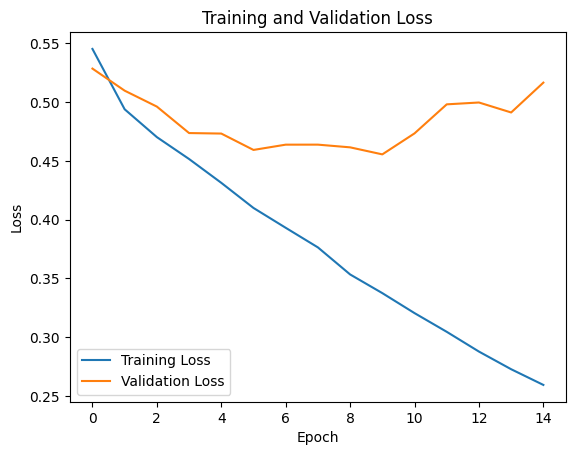

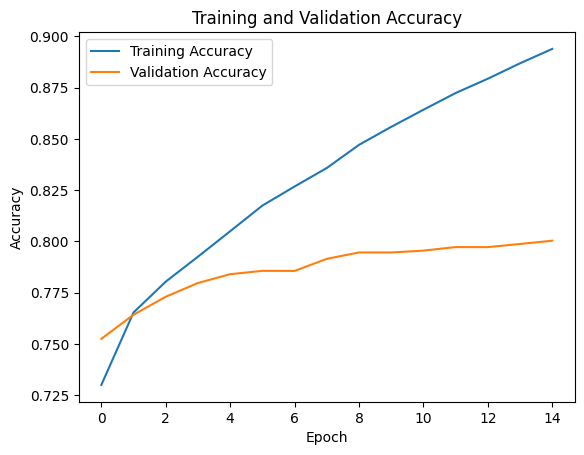

In [17]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

79/79 [==============================] - 7s 87ms/step
Accuracy: 0.7945905167083035
Classification Report:
               precision    recall  f1-score   support

           0       0.78      0.93      0.85     51026
           1       0.83      0.56      0.67     29832

    accuracy                           0.79     80858
   macro avg       0.81      0.75      0.76     80858
weighted avg       0.80      0.79      0.78     80858



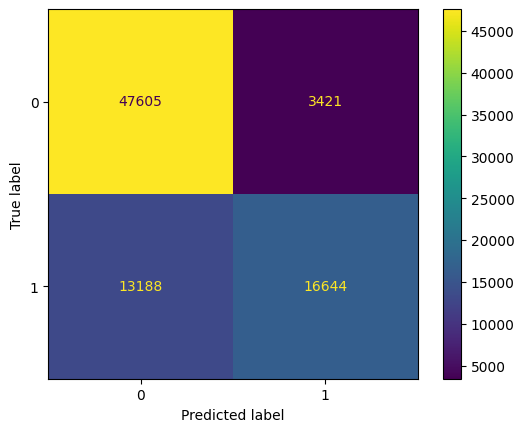

In [18]:
validation_generator = data_generator(X1_test, X2_test, y_test, batch_size, epochs)
y_pred_prob = model.predict(validation_generator, steps=validation_steps)
y_pred = (y_pred_prob > 0.5).astype(int)

accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')

report = classification_report(y_test, y_pred)
print('Classification Report:\n', report)

cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(cm).plot()